# Roman configurations

In [1]:
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from slsim.lens_pop import LensPop
import slsim.Sources as sources
import slsim.Pipelines as pipelines
import slsim.Deflectors as deflectors
from slsim.Pipelines.sl_hammocks_pipeline import SLHammocksPipeline
from astropy.cosmology import default_cosmology
from astropy.units import Quantity
import corner
from pprint import pprint

repo_dir = '/grad/bwedig/mejiro'
if repo_dir not in sys.path:
    sys.path.append(repo_dir)
    
from mejiro.exposure import Exposure
from mejiro.synthetic_image import SyntheticImage
from mejiro.instruments.roman import Roman

%matplotlib inline

In [2]:
# Import default Roman Space Telescope configuration
skypy_config = "roman-like.yml"

# Load Roman filters
speclite_filters = Roman.load_speclite_filters(sca=1)

In [3]:
# define a cosmology
cosmo = default_cosmology.get()

# define a sky area
sky_area = Quantity(value=1., unit="deg2")

# run skypy pipeline and make galaxy-galaxy population class
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=skypy_config,
    sky_area=sky_area,
    filters=None,
)

# Generate halo galaxy population using SLHammock pipeline. Halo galaxies from this simulation
# will be used as deflector population. One can specify minimum and maximum values for
# redshift and log10 of halo mass.
# halo_galaxy_pipeline = SLHammocksPipeline(
#     slhammocks_config=None,
#     sky_area=sky_area,
#     cosmo=cosmo
# )

In [4]:
# define limits in the intrinsic deflector and source population (in addition to the skypy config file)
kwargs_deflector_cut = {"band": "F129", "band_max": 25, "z_min": 0.01, "z_max": 3.0}
kwargs_source_cut = {"band": "F129", "band_max": 28, "z_min": 0.01, "z_max": 5.0}

lens_galaxies = deflectors.EllipticalLensGalaxies(
    galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=sky_area,
)

source_galaxies = sources.Galaxies(
    galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_source_cut,
    cosmo=cosmo,
    sky_area=sky_area,
    catalog_type="skypy",
)

# # Initiate deflector population class.
# lens_galaxies = deflectors.CompoundLensHalosGalaxies(
#     halo_galaxy_list=halo_galaxy_pipeline._pipeline,
#     kwargs_cut=kwargs_deflector_cut,
#     kwargs_mass2light={},
#     cosmo=cosmo,
#     sky_area=sky_area,
# )

# # Initiate source population class.
# source_galaxies = sources.Galaxies(
#     galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
#     kwargs_cut=kwargs_source_cut,
#     cosmo=cosmo,
#     sky_area=sky_area,
#     catalog_type="skypy",
# )

lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_galaxies,
    cosmo=cosmo,
    sky_area=sky_area,
)

/data/bwedig/.conda/envs/mejiro-v2/lib/python3.10/site-packages/slsim/Deflectors/elliptical_lens_galaxies.py:46: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  galaxy_list = param_util.catalog_with_angular_size_in_arcsec(


In [5]:
kwargs_lens_cut = {
    "min_image_separation": 0.1,
    "max_image_separation": 10,
    "mag_arc_limit": {"F158": 25, "F106": 21, "F062": 25},
}

lens_population = lens_pop.draw_population(kwargs_lens_cuts=kwargs_lens_cut)

/data/bwedig/.conda/envs/mejiro-v2/lib/python3.10/site-packages/slsim/ParamDistributions/kext_gext_distributions.py:126: UserWarning: No file found, provide 0 instead.
  warnings.warn("No file found, provide 0 instead.")


In [6]:
sample_gglens = lens_population[0]

pprint(sample_gglens.__dict__)

{'_lens_cosmo': <lenstronomy.Cosmo.lens_cosmo.LensCosmo object at 0x7efd77e814e0>,
 '_lens_equation_solver': 'lenstronomy_analytical',
 '_magnification_limit': 0.01,
 '_max_redshift_source_index': 0,
 '_source_type': 'extended',
 'cosmo': FlatLambdaCDM(name='Planck18',
                        H0=<Quantity 67.66 km / (Mpc s)>,
                        Om0=0.30966,
                        Tcmb0=<Quantity 2.7255 K>,
                        Neff=3.046,
                        m_nu=<Quantity [0.  , 0.  , 0.06] eV>,
                        Ob0=0.04897),
 'deflector': <slsim.Deflectors.deflector.Deflector object at 0x7efd77e133a0>,
 'los_class': <slsim.LOS.los_individual.LOSIndividual object at 0x7efd77e81000>,
 'max_redshift_source_class': <slsim.Sources.source.Source object at 0x7efd77e12c20>,
 'source': [<slsim.Sources.source.Source object at 0x7efd77e12c20>],
 'source_number': 1,
 'test_area': 167.22103252295494}


In [7]:
deflector_bands = [k.split("_")[1] for k in sample_gglens.deflector._deflector._deflector_dict.keys() if k.startswith("mag_")]
print(deflector_bands)

['F062', 'F087', 'F106', 'F129', 'F158', 'F184', 'F146', 'F213']


In [8]:
source_bands = [k.split("_")[1] for k in sample_gglens.source[0].source_dict.keys() if k.startswith("mag_")]
print(source_bands)

['F062', 'F087', 'F106', 'F129', 'F158', 'F184', 'F146', 'F213']


In [9]:
kwargs_model, kwargs_params = sample_gglens.lenstronomy_kwargs(band='F106')
pprint(kwargs_model)
pprint(kwargs_params)

{'lens_light_model_list': ['SERSIC_ELLIPSE'],
 'lens_model_list': ['SIE', 'SHEAR', 'CONVERGENCE'],
 'source_light_model_list': ['SERSIC_ELLIPSE']}
{'kwargs_lens': [{'center_x': 0.06989811495036079,
                  'center_y': -0.0660028625747761,
                  'e1': 0.36141454283076646,
                  'e2': 0.09278359738530724,
                  'theta_E': 0.7423440071684397},
                 {'dec_0': 0, 'gamma1': -0.0, 'gamma2': -0.0, 'ra_0': 0},
                 {'dec_0': 0, 'kappa': 0.0, 'ra_0': 0}],
 'kwargs_lens_light': [{'R_sersic': 0.6746599194037378,
                        'center_x': 0.06989811495036079,
                        'center_y': -0.0660028625747761,
                        'e1': 0.2423959769370482,
                        'e2': -0.0183639059469971,
                        'magnitude': 23.9596060901365,
                        'n_sersic': 4.0}],
 'kwargs_ps': None,
 'kwargs_source': [{'R_sersic': 0.2864789226957039,
                    'center_x': -0.0453

{'lens_stellar_mass': 977409654003.7206,
 'lens_velocity_dispersion': 318.1035069180407,
 'magnification': [2.1572878148080696],
 'magnitudes': {'lens': {'F062': 25.31638290929369,
                         'F087': 24.96369787259651,
                         'F106': 23.9596060901365,
                         'F129': 22.97223751280789,
                         'F146': 22.29807037949136,
                         'F158': 21.906108678706293,
                         'F184': 21.45793326374795,
                         'F213': 21.118396579379453},
                'lensed_source': {'F062': 25.500925653675434,
                                  'F087': 25.177803863752867,
                                  'F106': 25.00159434812006,
                                  'F129': 24.8952958657035,
                                  'F146': 24.766725445488536,
                                  'F158': 24.667238282726974,
                                  'F184': 24.465433844571177,
                      

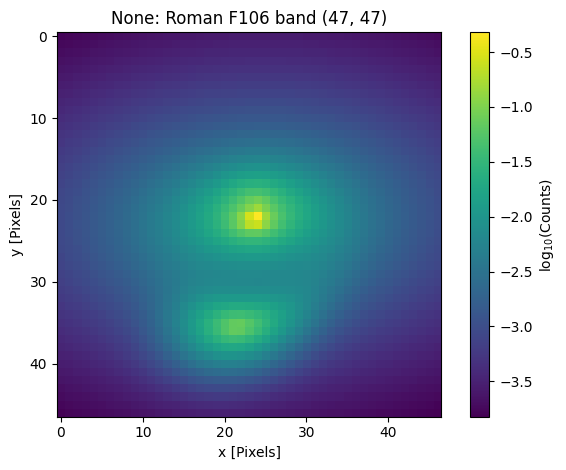

In [17]:
from mejiro.galaxy_galaxy import GalaxyGalaxy

strong_lens = GalaxyGalaxy.from_slsim(sample_gglens)
pprint(strong_lens.physical_params)

synthetic_image = SyntheticImage(strong_lens, instrument=Roman(), band='F106')
synthetic_image.plot()

In [10]:
roman = Roman()

previous_kwargs_model, previous_kwargs_params = None, None

for band in roman.bands:
    if previous_kwargs_model is None and previous_kwargs_params is None:
        previous_kwargs_model, previous_kwargs_params = sample_gglens.lenstronomy_kwargs(band=band)
    else:
        kwargs_model, kwargs_params = sample_gglens.lenstronomy_kwargs(band=band)
        assert previous_kwargs_model == kwargs_model
        assert kwargs_params['kwargs_lens'] == previous_kwargs_params['kwargs_lens']
        previous_kwargs_params['kwargs_lens_light'][0].pop('magnitude')
        kwargs_params['kwargs_lens_light'][0].pop('magnitude')
        assert kwargs_params['kwargs_lens_light'] == previous_kwargs_params['kwargs_lens_light']
        previous_kwargs_params['kwargs_source'][0].pop('magnitude')
        kwargs_params['kwargs_source'][0].pop('magnitude')
        assert kwargs_params['kwargs_source'] == previous_kwargs_params['kwargs_source']

        previous_kwargs_model, previous_kwargs_params = sample_gglens.lenstronomy_kwargs(band=band)

In [11]:
# print("Number of lenses:", len(lens_population))

# lens_samples = []
# labels = [
#     r"$\sigma_v$",
#     r"$\log(M_{*})$",
#     r"$\log(h_{m})$",
#     r"$\theta_E$",
#     r"$z_{\rm l}$",
#     r"$z_{\rm s}$",
#     r"$m_{\rm source}$",
#     r"$m_{\rm lens}$",
# ]

# for gg_lens in lens_population:
#     vel_disp = gg_lens.deflector_velocity_dispersion()
#     m_star = gg_lens.deflector_stellar_mass()
#     halo_mass = gg_lens.deflector.halo_properties[0]
#     theta_e = gg_lens.einstein_radius[0]
#     zl = gg_lens.deflector_redshift
#     zs = gg_lens.source_redshift_list[0]
#     source_mag = gg_lens.extended_source_magnitude(band="i", lensed=True)[0]
#     deflector_mag = gg_lens.deflector_magnitude(band="i")
#     lens_samples.append(
#         [
#             vel_disp,
#             np.log10(m_star),
#             np.log10(halo_mass),
#             theta_e,
#             zl,
#             zs,
#             source_mag,
#             deflector_mag,
#         ]
#     )

print("Number of lenses:", len(lens_population))

lens_samples = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
]

for gg_lens in lens_population:
    vel_disp = gg_lens.deflector_velocity_dispersion()
    m_star = gg_lens.deflector_stellar_mass()
    theta_e = gg_lens.einstein_radius[0]
    zl = gg_lens.deflector_redshift
    zs = gg_lens.source_redshift_list[0]
    source_mag = gg_lens.extended_source_magnitude(band="F184", lensed=True)[0]
    deflector_mag = gg_lens.deflector_magnitude(band="F184")
    lens_samples.append(
        [vel_disp, np.log10(m_star), theta_e, zl, zs, source_mag, deflector_mag]
    )

Number of lenses: 439


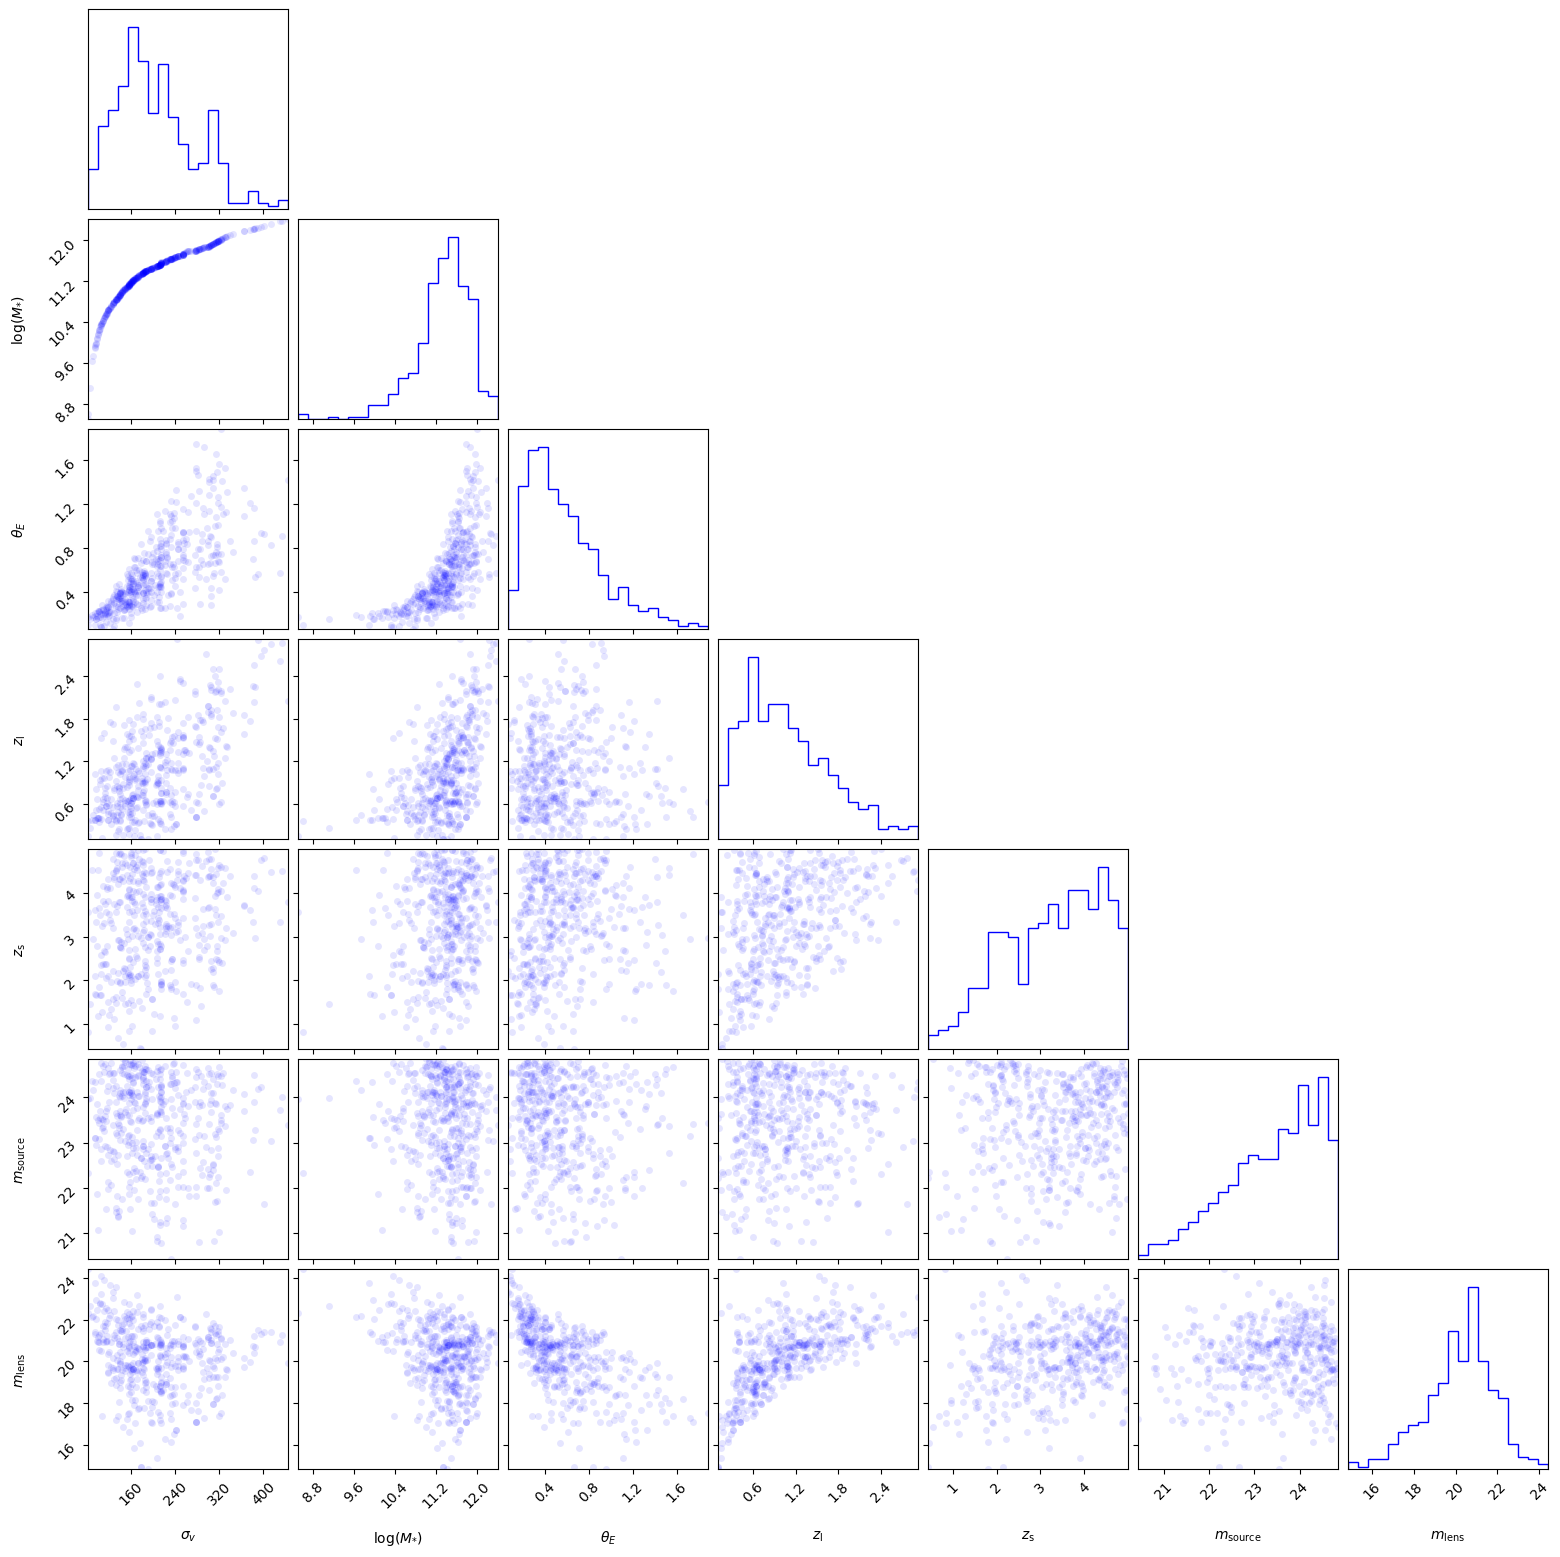

In [12]:
hist2dkwargs = {
    "plot_density": False,
    "plot_contours": False,
    "plot_datapoints": True,
    "color": "b",
    "data_kwargs": {"ms": 5},
}
corner.corner(np.array(lens_samples), labels=labels, **hist2dkwargs)
plt.show()